# Systems Immunogenetics Project

## Buxco Parsing Workflow

### McWeeney Lab, Oregon Health & Science University

** Authors: Gabrielle Choonoo (choonoo@ohsu.edu) and Michael Mooney (mooneymi@ohsu.edu) **

## Introduction

This is the step-by-step workflow for parsing the Buxco data into databases for each batch.

Required Files:
* Buxco Data
* This notebook (notebook.ipynb): [[Download here]](https://raw.githubusercontent.com/gchoonoo/Buxco_notebook/master/notebook.ipynb)
* R Script (utilities_MM.R): [[Download here]](https://raw.githubusercontent.com/gchoonoo/Buxco_notebook/master/utilities_MM.R)

Required R packages:
- `plethy`
- `plyr`
- `R.utils`
- `RColorBrewer`
- `reshape2`
- `IRanges`
- `ggplot2`

**Note: this notebook can also be downloaded as an R script (only the code blocks seen below will be included): [[Download R script here]](https://raw.githubusercontent.com/gchoonoo/Buxco_notebook/master/parse_buxco.r)

** All code is available on GitHub: [https://github.com/gchoonoo/Buxco_notebook](https://github.com/gchoonoo/Buxco_notebook) **

# Source functions for plotting

In [2]:
source('utilities_MM.R')

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: R.oo
Loading required package: R.methodsS3
R.met

# Load Buxco Data and clean

In [3]:
# Set file path of data
aug_2013 = '2013_iAugust - buxco.txt'

# Read in data
aug_2013 = read.delim(aug_2013, sep=',', header=T, as.is=T, skip=1)

# Save number of columns
length(names(aug_2013)) -> output_cols

# Set data header and footer
table_header='Table WBPth'
table_footer='Table Metabolism'
table_footer_cols = as.character(tail(aug_2013, 1))[!is.na(tail(aug_2013, 1))]

# Subset to exclude last two rows 
aug_2013 = aug_2013[1:(dim(aug_2013)[1]-2), ]

# Annotate Mating, RIX, Virus, and Sex
aug_2013$Mating = sapply(strsplit(aug_2013$Subject, ' +'), '[', 1)
aug_2013$RIX_ID = sapply(strsplit(aug_2013$Subject, ' +'), '[', 2)
aug_2013$Virus = sapply(strsplit(aug_2013$Subject, ' +'), '[', 3)
aug_2013$Sex = NA
aug_2013$Sex[grepl('f|F', aug_2013$RIX_ID)] = 'F'
aug_2013$Sex[grepl('m|M', aug_2013$RIX_ID)] = 'M' 
aug_2013$RIX_ID = gsub('f|m', '', aug_2013$RIX_ID)

# Check if Virus is annotated correctly
unique(aug_2013[grep("x",aug_2013[,"Subject"]),"Virus"])

# Code chunk to annotate virus based on weight sheets
# aug_2013$Virus2 = NA
# for(i in 1:dim(virus_annot)[1]){
#   print(i)
#   aug_2013[paste(aug_2013[,"Mating"],aug_2013[,"RIX_ID"],sep="_") %in% virus_annot[i,1],"Virus2"] <- as.character(virus_annot[i,2])
# }
# 
# aug_2013[which(is.na(aug_2013[,"Virus"])),"Virus"] <- aug_2013[which(is.na(aug_2013[,"Virus"])),"Virus2"]

# Standardize Virus column: SARS, FLU, Mock
aug_2013[which(aug_2013[,"Virus"] == "sars"),"Virus"] <- "SARS"
aug_2013[which(aug_2013[,"Virus"] == "flu"),"Virus"] <- "FLU"
aug_2013[which(aug_2013[,"Virus"] == "mock"),"Virus"] <- "Mock"

# Clean sample names
aug_2013$Subject_cleaned = aug_2013$Subject
aug_2013[grep("x",aug_2013[,"Subject"]),"Subject_cleaned"] = paste(aug_2013[grep("x",aug_2013[,"Subject"]),"Mating"], paste0(tolower(aug_2013[grep("x",aug_2013[,"Subject"]),"Sex"]), aug_2013[grep("x",aug_2013[,"Subject"]),"RIX_ID"]), aug_2013[grep("x",aug_2013[,"Subject"]),"Virus"], sep=' ')
aug_2013$Subject = aug_2013$Subject_cleaned

# Check Unique Sample Names
# Default rows that are removed in parsing process: burn.in.lines=c("Measurement", "Create measurement", "Waiting for","Site Acknowledgement Changed")
# "Subject" and blanks are also removed.
# Note any others that do not have the form Mating RIX Virus (i.e. "Responding to")
unique(aug_2013$Subject)

# Output in Buxco format
colnames(aug_2013)[output_cols] = ''
cleaned_file = '2013_iAugust - buxco_cleaned.txt'
cat(table_header, file=cleaned_file, sep='\n')
write.table(aug_2013[,1:output_cols], file=cleaned_file, append=T, sep=',', col.names=T, row.names=F, quote=F, na='')
cat(table_footer, file=cleaned_file, append=T, sep='\n')
cat(table_footer_cols, file=cleaned_file, append=T, sep=',')
cat(',\n', file=cleaned_file, append=T)

[1] "sars" "flu"  "mock"

[1] "3032x16188 f82 SARS"                       
 [2] "Measurement 1"                             
 [3] "Waiting for 1..."                          
 [4] "Create measurement '1'. Duration: 00:05:00"
 [5] "3032x16188 f83 SARS"                       
 [6] "3032x16188 f109 SARS"                      
 [7] "3032x16188 f69 FLU"                        
 [8] "3032x16188 f70 FLU"                        
 [9] "3032x16188 f79 FLU"                        
[10] "3032x16188 f71 Mock"                       
[11] "3032x16188 f80 Mock"                       
[12] "8004x8043 f87 SARS"                        
[13] "8004x8043 f86 SARS"                        
[14] "8004x8043 f67 SARS"                        
[15] "8004x8043 f75 FLU"                         
[16] "8004x8043 f76 FLU"                         
[17] "8004x8043 f82 FLU"                         
[18] "8004x8043 f77 Mock"                        
[19] "8004x8043 f78 Mock"                        
[20] "8002x3032 f29 Mock"                        
[21] "8002x3032 f6 Mock"                         
[22] "8002x3032 f5 FLU"                          
[23] "8002x3032 f28 FLU"                         
[24] "8002x3032 f27 FLU"                         
[25] "8002x3032 f61 SARS"                        
[26] "8002x3032 f59 SARS"                        
[27] "8002x3032 f60 SARS"                        
[28] "Site Acknowledgement Changed: False"

Warning message:
In write.table(aug_2013[, 1:output_cols], file = cleaned_file, append = T, : appending column names to file

# Create Buxco Database

In [4]:
# Set the file path to the cleaned buxco data
aug_2013_path <- "2013_iAugust - buxco_cleaned.txt"

# Set the file size to the number of rows in the file
chunk.size <- dim(aug_2013)[1]

# Set the file path of where to save the data base
db.name <- file.path("August2013_database.db")

# Parse the data, add "Responding to" in the burn.in.lines if necessary (Note: This takes a few minutes to run)
parse.buxco(file.name=aug_2013_path, chunk.size=chunk.size, db.name=db.name, verbose=FALSE)

# Note any parsing warnings that get printed (Sample Name and Break number), none in this case

BuxcoDB object:
Database: August2013_database.db 
Annotation Table: Additional_labels 
| PARSE_DATE: 2016-04-25 08:47:02
| DBSCHEMA: Buxco
| package: plethy
| Db type: BuxcoDB
| DBSCHEMAVERION: 1.0

# Add Annotation

In [5]:
# Read in the data base that was created
August2013_database.db <- makeBuxcoDB(db.name=file.path("August2013_database.db"))

# Add the Virus, Day and Break type level (EXP, ACC, ERR, or UNK)
addAnnotation(August2013_database.db, query=virus.query, index=TRUE)  
addAnnotation(August2013_database.db, query=day.infer.query, index=TRUE)  
addAnnotation(August2013_database.db, query=break.type.query, index=TRUE)

[1] TRUE

[1] TRUE

[1] TRUE

# Save parsing warnings, error, and unknown rows

In [6]:
# Check Break type levels
annoLevels(August2013_database.db)

# Subset the parsing warning and error rows in each file
# Example:
acc.aug2013 <- retrieveData(August2013_database.db, variables=variables(August2013_database.db), Break_type_label = 'ACC')

# acc.feb2013[which(acc.feb2013[,1] == "16513x16188 f105 FLU" & acc.feb2013[,"Break_number"] == 158),] -> acc.feb2013_warning

$Virus
[1] "FLU"  "Mock" "SARS"

$Days
 [1]  0  4  5  6  7  9 11 14 19 26

$Break_type_label
[1] "ACC" "ERR" "EXP"

# Create Boxplot

[1] "f"     "TVb"   "MVb"   "Penh"  "PAU"   "Rpef"  "Comp"  "PIFb"  "PEFb" 
[10] "Ti"    "Te"    "EF50"  "Tr"    "Tbody" "Tc"    "RH"    "Rinx"

    Break_type_label
Days  EXP
  0  3580
  4  3448
  5  3597
  6  3596
  7  3594
  9  3586
  11 3597
  14 3595
  19 3580
  26 3567

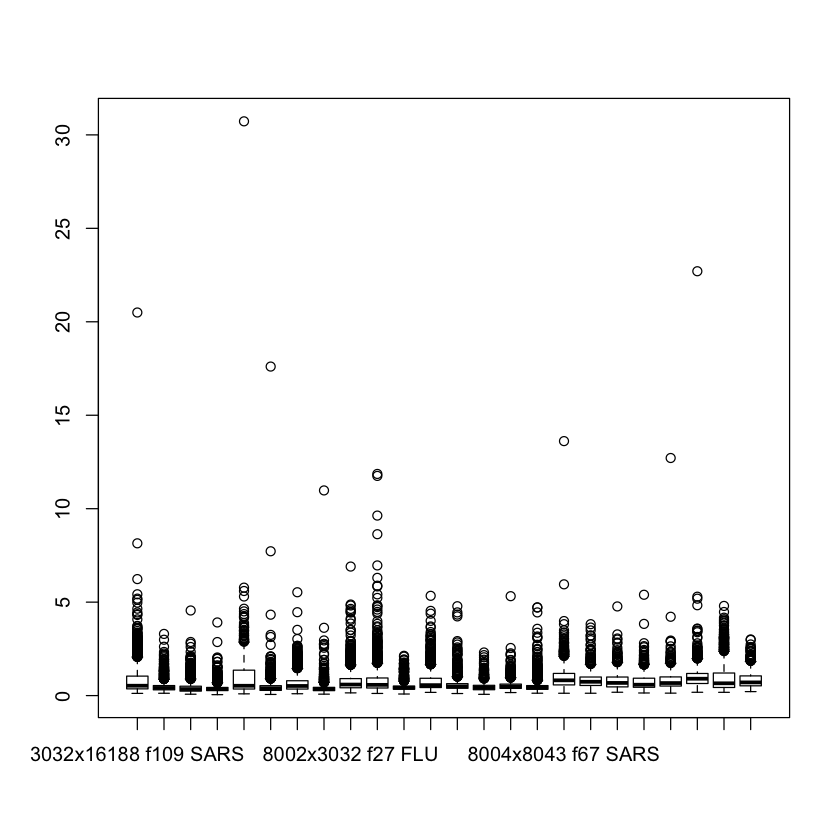

In [7]:
# Observe variables
variables(August2013_database.db)

# Choose the variable and category to visualize
exp.penh <- retrieveData(August2013_database.db, variables="Penh", Break_type_label = 'EXP')

# Get table of categories
with(exp.penh, table(Days, Break_type_label))

# Create Boxplot
boxplot(Value~Sample_Name, data=exp.penh)

# Create Heatmap

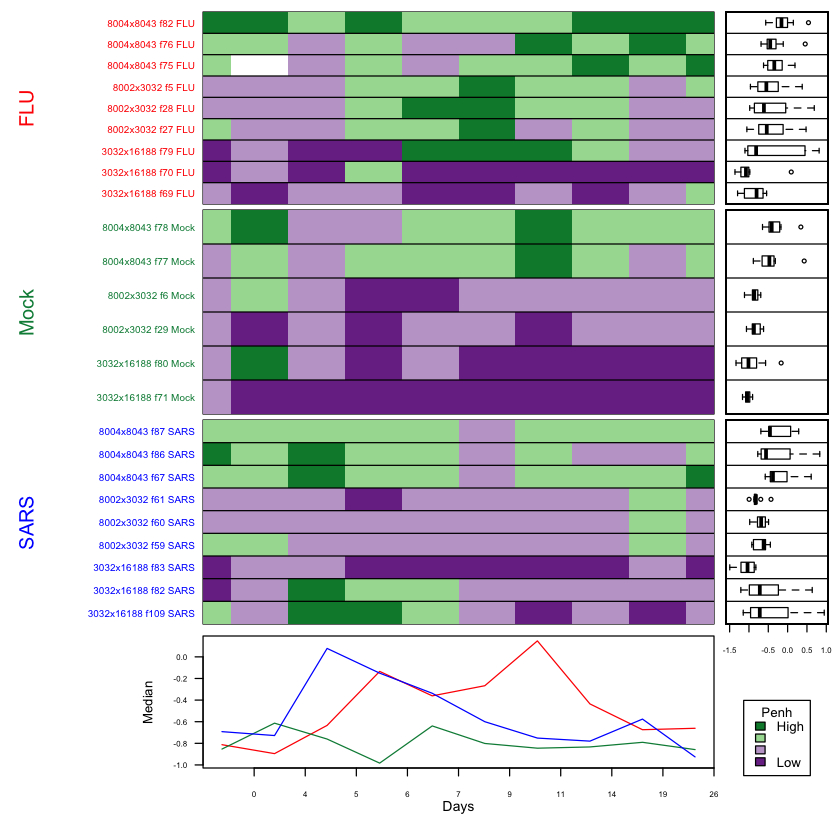

In [9]:
# Output results for experiment rows only (EXP) and stratify by virus 
# Make sure that the names in outer.cols match the virus labels in the raw data (e.g. SARS vs. sars)
mvtsplot(August2013_database.db, outer.group.name='Virus', outer.cols=c(FLU="red", SARS="blue", Mock="springgreen4"), Break_type_label='EXP')